In [1]:
import tensorflow as tf
import numpy as np
import glob, os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class JumpingWindow:
    
    
    def __init__(self, size, overlap, strict_size=True):
        if (
            not isinstance(size, int) or
            not isinstance(overlap, int) or
            not isinstance(strict_size, bool) or
            overlap >= size
        ):
            title = "ERROR: Wrong values in JumpingWindow constructor."
            description = "Expecting: size(int), overlap(int), strict_size(bool), AND overlap < size"
            provided = "size({}), overlap({}), strict_size({}), overlap < size? {}".format(
                    type(size),
                    type(overlap),
                    type(strict_size),
                    overlap < size
                )
            raise Exception(title + "\n" + description + "\n" + provided)
        self.windows = []
        self.entries = []
        self.size = size
        self.overlap = overlap
        self.strict_size = strict_size
        self.transformed = False


    def add(self, element):
        if self.transformed:
            raise Exception("Cannot add the elements to the window, once it has been transformed!")
        self.entries.append(element)


    def transform_entries_to_windows(self):
        for i in range(0, len(self.entries), self.size-self.overlap):
            window = self.entries[i:i+self.size]
            if (self.strict_size and (len(window) != self.size)):
                continue
            self.windows.append(window)
        self.transformed = True
    
    
    def getWindow(self, window_number):
        return windows[window_number]
    
    
    def getAllWindows(self):
        return self.windows[:]


    def __str__(self):
        result = "\n---------- Jumping Window ----------\n"
        for i in range(len(self.windows)):
            result = result + "Window {}:\t{}\n".format(i, self.windows[i])
        result = result + "------------------------------------\n"
        return result
    
        

In [3]:
def shapeMatrix(one_dimensional_list, num_rows, num_cols):
    if (num_rows * num_cols != len(one_dimensional_list)):
        # not possible to transform the values
        return None
    else:
        matrix = []
        for i in range(num_rows):
            row = []
            for j in range(num_cols):
                row.append(j)
            matrix.append(row)
        return matrix


In [4]:
def getValuesFromFile(filename):
    values = []

    f = open("merged_test_0026.csv", "r")
    line = f.readline() # col titles
    line = f.readline() # first row
    while line:
        values.append(np.float32(line.split(",")[0]))
        line = f.readline()
    f.close()
    
    return values

In [5]:
# break down into overlapping jumping windows
def createJumpingWindows(values):
    jws = JumpingWindow(30, 5)
    for value in values:
        jws.add(value)
    jws.transform_entries_to_windows()
    return jws

In [6]:
#here I create default graph 
tf.reset_default_graph()

In [7]:
# parameters for my stacked autoencoders
num_inputs = 30
neurons_hid1 = 20
neurons_hid2 = 10
neurons_hid3 = neurons_hid1
num_output = num_inputs

In [8]:
learning_rate = 0.001

In [9]:
activation_fun = tf.nn.sigmoid

In [10]:
#now I begin everything I need for the session of my Graph
X = tf.placeholder(tf.float32,shape=[None,None])

In [11]:
#now here I set my weight: where I am trying to achieve the weight of the tensors
initializer = tf.variance_scaling_initializer()

In [12]:
#here I create my weight variables

w1 = tf.Variable(initializer([num_inputs,neurons_hid1]),dtype=tf.float32)
w2 = tf.Variable(initializer([neurons_hid1,neurons_hid2]),dtype=tf.float32)
w3 = tf.Variable(initializer([neurons_hid2,neurons_hid3]),dtype=tf.float32)
w4 = tf.Variable(initializer([neurons_hid3,num_output]),dtype=tf.float32)


In [13]:
#now I create my bias
b1 = tf.Variable(tf.zeros(neurons_hid1))
b2 = tf.Variable(tf.zeros(neurons_hid2))
b3 = tf.Variable(tf.zeros(neurons_hid3))
b4 = tf.Variable(tf.zeros(num_output))


In [14]:
activation_func = tf.nn.sigmoid

In [15]:
#now I create my hidden layers
hid_layer1 = activation_func(tf.matmul(X,w1)+b1)
hid_layer2 = activation_func(tf.matmul(hid_layer1,w2)+b2) 
hid_layer3 = activation_func(tf.matmul(hid_layer2,w3)+b3) 
output_layer = activation_func(tf.matmul(hid_layer3,w4)+b4) 


In [16]:
#now I define my cost functions(loss)
loss = tf.reduce_mean(tf.squared_difference(output_layer, X))

In [17]:
#now I define my optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)

In [18]:
#now I define my trianing operation attempting to minimize the loss function
train = optimizer.minimize(loss)

In [19]:
init = tf.global_variables_initializer()

In [35]:
# Training
num_epochs = 20

total_training_losses = []

with tf.Session() as sess:
    
    sess.run(init)
    
    for filename in glob.glob("*.csv"):
        print("===== Learning file: {} =====".format(filename))
        
        values = getValuesFromFile(filename)
        jws = createJumpingWindows(values)
        
        training_losses_per_file = []
    
        for epoch in range(num_epochs):

            for jw in jws.getAllWindows():
                matrix = shapeMatrix(jw,1,30)
                sess.run(train, feed_dict={X:matrix})

            training_loss = loss.eval(feed_dict={X:matrix})
            training_losses_per_file.append(training_loss)
            
            print("\tEpoch: {}\tLoss: {}".format(epoch, training_loss))
        
        print(
            "Completed file: {}\tTraining Losses: [{:0.3f}..{:0.3f}]".format(
                filename,
                training_losses_per_file[0],
                training_losses_per_file[-1]
            )
        )
        
        total_training_losses.append(training_losses_per_file[:])
        
    model_filename = "model.ckpt"
    saver = tf.train.Saver()
    saver.save(sess, model_filename)
    print("===== ========== =====\nSaved model in file: {}".format(model_filename))
        

===== Learning file: merged_test_0055.csv =====
	Epoch: 0	Loss: 269.08740234375
	Epoch: 1	Loss: 267.8641052246094
	Epoch: 2	Loss: 266.6685485839844
	Epoch: 3	Loss: 265.5252990722656
	Epoch: 4	Loss: 264.4192199707031
	Epoch: 5	Loss: 263.3459777832031
	Epoch: 6	Loss: 262.37652587890625
	Epoch: 7	Loss: 261.51922607421875
	Epoch: 8	Loss: 260.7865905761719
	Epoch: 9	Loss: 260.1778869628906
	Epoch: 10	Loss: 259.6820068359375
	Epoch: 11	Loss: 259.2823486328125
	Epoch: 12	Loss: 258.9541931152344
	Epoch: 13	Loss: 258.6930847167969
	Epoch: 14	Loss: 258.48211669921875
	Epoch: 15	Loss: 258.3103332519531
	Epoch: 16	Loss: 258.1692199707031
	Epoch: 17	Loss: 258.0523376464844
	Epoch: 18	Loss: 257.9547424316406
	Epoch: 19	Loss: 257.8725891113281
Completed file: merged_test_0055.csv	Training Losses: [269.087..257.873]
===== Learning file: merged_test_0033.csv =====
	Epoch: 0	Loss: 257.8028564453125
	Epoch: 1	Loss: 257.74322509765625
	Epoch: 2	Loss: 257.69183349609375
	Epoch: 3	Loss: 257.6472473144531
	E

	Epoch: 0	Loss: 257.1424560546875
	Epoch: 1	Loss: 257.1423645019531
	Epoch: 2	Loss: 257.1422424316406
	Epoch: 3	Loss: 257.1421813964844
	Epoch: 4	Loss: 257.14208984375
	Epoch: 5	Loss: 257.1419982910156
	Epoch: 6	Loss: 257.1419372558594
	Epoch: 7	Loss: 257.1418151855469
	Epoch: 8	Loss: 257.1417541503906
	Epoch: 9	Loss: 257.14166259765625
	Epoch: 10	Loss: 257.1415710449219
	Epoch: 11	Loss: 257.1415100097656
	Epoch: 12	Loss: 257.1414489746094
	Epoch: 13	Loss: 257.141357421875
	Epoch: 14	Loss: 257.1412658691406
	Epoch: 15	Loss: 257.1412048339844
	Epoch: 16	Loss: 257.1411437988281
	Epoch: 17	Loss: 257.14105224609375
	Epoch: 18	Loss: 257.1409912109375
	Epoch: 19	Loss: 257.1408996582031
Completed file: merged_test_0037.csv	Training Losses: [257.142..257.141]
===== Learning file: merged_test_0062.csv =====
	Epoch: 0	Loss: 257.14080810546875
	Epoch: 1	Loss: 257.1407470703125
	Epoch: 2	Loss: 257.14068603515625
	Epoch: 3	Loss: 257.140625
	Epoch: 4	Loss: 257.14056396484375
	Epoch: 5	Loss: 257.1405

	Epoch: 14	Loss: 257.1346435546875
	Epoch: 15	Loss: 257.1346435546875
	Epoch: 16	Loss: 257.1346435546875
	Epoch: 17	Loss: 257.1346435546875
	Epoch: 18	Loss: 257.1346130371094
	Epoch: 19	Loss: 257.1346130371094
Completed file: merged_test_0047.csv	Training Losses: [257.135..257.135]
===== Learning file: merged_test_0027.csv =====
	Epoch: 0	Loss: 257.13458251953125
	Epoch: 1	Loss: 257.13458251953125
	Epoch: 2	Loss: 257.13458251953125
	Epoch: 3	Loss: 257.1345520019531
	Epoch: 4	Loss: 257.1345520019531
	Epoch: 5	Loss: 257.1345520019531
	Epoch: 6	Loss: 257.1345520019531
	Epoch: 7	Loss: 257.1344909667969
	Epoch: 8	Loss: 257.1344909667969
	Epoch: 9	Loss: 257.1344909667969
	Epoch: 10	Loss: 257.1344909667969
	Epoch: 11	Loss: 257.1344909667969
	Epoch: 12	Loss: 257.13446044921875
	Epoch: 13	Loss: 257.13446044921875
	Epoch: 14	Loss: 257.13446044921875
	Epoch: 15	Loss: 257.13446044921875
	Epoch: 16	Loss: 257.1344299316406
	Epoch: 17	Loss: 257.1344299316406
	Epoch: 18	Loss: 257.1344299316406
	Epoch:

	Epoch: 19	Loss: 257.1336364746094
Completed file: merged_test_0032.csv	Training Losses: [257.134..257.134]
===== Learning file: merged_test_0060.csv =====
	Epoch: 0	Loss: 257.1336364746094
	Epoch: 1	Loss: 257.1336364746094
	Epoch: 2	Loss: 257.1336364746094
	Epoch: 3	Loss: 257.1336364746094
	Epoch: 4	Loss: 257.1336364746094
	Epoch: 5	Loss: 257.1336364746094
	Epoch: 6	Loss: 257.1336364746094
	Epoch: 7	Loss: 257.1336364746094
	Epoch: 8	Loss: 257.1336364746094
	Epoch: 9	Loss: 257.1336364746094
	Epoch: 10	Loss: 257.13360595703125
	Epoch: 11	Loss: 257.13360595703125
	Epoch: 12	Loss: 257.13360595703125
	Epoch: 13	Loss: 257.13360595703125
	Epoch: 14	Loss: 257.13360595703125
	Epoch: 15	Loss: 257.13360595703125
	Epoch: 16	Loss: 257.13360595703125
	Epoch: 17	Loss: 257.13360595703125
	Epoch: 18	Loss: 257.13360595703125
	Epoch: 19	Loss: 257.13360595703125
Completed file: merged_test_0060.csv	Training Losses: [257.134..257.134]
===== Learning file: merged_test_0029.csv =====
	Epoch: 0	Loss: 257.133

Text(0, 0.5, 'Losses')

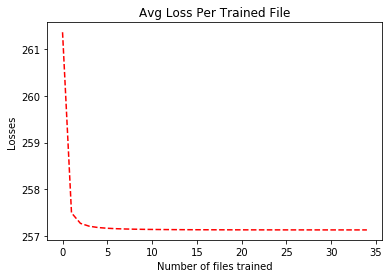

In [38]:
to_plot = []
for training_loss_per_file in total_training_losses:
    avg_loss = sum(training_loss_per_file) / len(training_loss_per_file)
    to_plot.append(avg_loss)
    
plt.plot(to_plot, 'r--')
plt.title('Avg Loss Per Trained File')
plt.xlabel('Number of files trained')
plt.ylabel('Losses')

In [39]:
# Evaluating

# Craete a list of random numbers representing a test
import random
new_test_values = []
for x in range(360):
    new_test_values.append(random.uniform(-100,100))

jws = createJumpingWindows(new_test_values)

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, model_filename)
    losses_per_segment = []
    for jw in jws.getAllWindows():
        matrix = shapeMatrix(jw,1,30)
        segment_loss = loss.eval(feed_dict={X:matrix})
        losses_per_segment.append(segment_loss)
    
    print(
        "\n===== RESULT: =====\nAvg RSME for segments in the new test: {:0.5f}\n===== ======= =====".format(
            sum(losses_per_segment) / len(losses_per_segment)
        )
    )

W0828 13:29:36.557221 140421599201088 deprecation.py:323] From /home/steve/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.



===== RESULT: =====
Avg RSME for segments in the new test: 257.13358
===== ======= =====
